In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'loan-approval-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/loan-approval-prediction-dataset


In [3]:
data = pd.read_csv(path + '/loan_approval_dataset.csv')

In [4]:
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
data.shape

(4269, 13)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [7]:
data.isnull().sum()

,0
loan_id,0
no_of_dependents,0
education,0
self_employed,0
income_annum,0
loan_amount,0
loan_term,0
cibil_score,0
residential_assets_value,0
commercial_assets_value,0


In [8]:
data.columns = data.columns.str.strip()

In [9]:
data['loan_status'] = data['loan_status'].str.strip().str.title().map({'Approved': 1, 'Rejected': 0})

In [10]:
cat_cols = ['education', 'self_employed']
for col in cat_cols:
    data[col] = data[col].str.strip()

In [11]:
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])

In [12]:
X = data.drop(['loan_id','loan_status'], axis=1)
y = data['loan_status']

In [13]:
y.value_counts()

,count
loan_status,
1,2656
0,1613


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
print(f"Before SMOTE: {np.bincount(y_train)}")

Before SMOTE: [1290 2125]


In [16]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {np.bincount(y_train_res)}")

After SMOTE: [2125 2125]


In [17]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)
}

In [18]:
trained_models = {}

for name, model in models.items():
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline

In [23]:

results = []

for name, pipeline in trained_models.items():
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))

    results.append({
        'Model': name,
        'Precision': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall'],
        'F1-Score': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       323
           1       0.95      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.92      0.92      0.92       854

ROC-AUC: 0.9732

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       323
           1       0.98      0.99      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

ROC-AUC: 0.9764

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.98       531

    accuracy                           0.98       854
   macro avg       0.

In [26]:
summary = pd.DataFrame(results)
print("FINAL MODEL COMPARISON \n")
print(summary.round(4))

FINAL MODEL COMPARISON 

                 Model  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression     0.9241  0.9227    0.9231   0.9732
1        Decision Tree     0.9789  0.9789    0.9789   0.9764
2        Random Forest     0.9813  0.9813    0.9813   0.9988


In [27]:
best_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

In [28]:
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

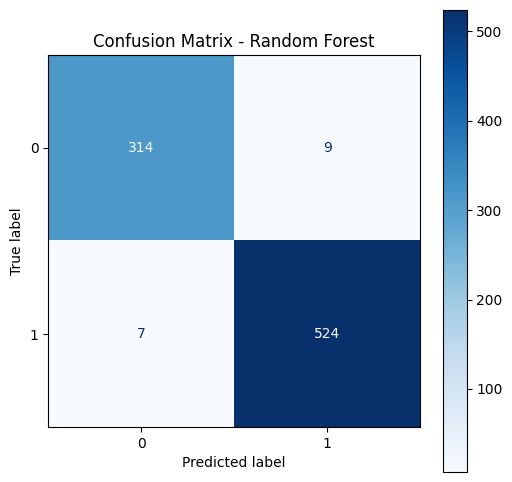

In [31]:
fig, ax1 = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1, cmap='Blues')
ax1.set_title('Confusion Matrix - Random Forest')
plt.show()

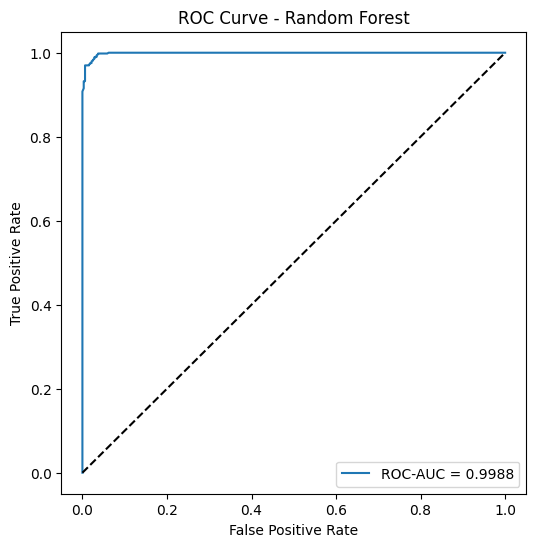

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()